# Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning.

## Pablo Spínola López - A01753922

Iniciamos importando las librerías y dependencias que se utilizarán a lo largo de la implementación y la visualización del modelo y su desempeño

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, shutil, pathlib
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import AdamW
from keras.models import Sequential

In [2]:
np.random.seed(35)
tf.random.set_seed(35)

In [3]:
# Directory where the five types of rice grains are stored
dataset_directory = pathlib.Path("DataSet")

# Automatically split into training and validation sets
train_dataset = image_dataset_from_directory(
    dataset_directory / "train",
    image_size=(250, 250),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    dataset_directory / "validation",
    image_size=(250, 250),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    dataset_directory / "test",
    image_size=(250, 250),
    batch_size=32)

Found 7000 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.


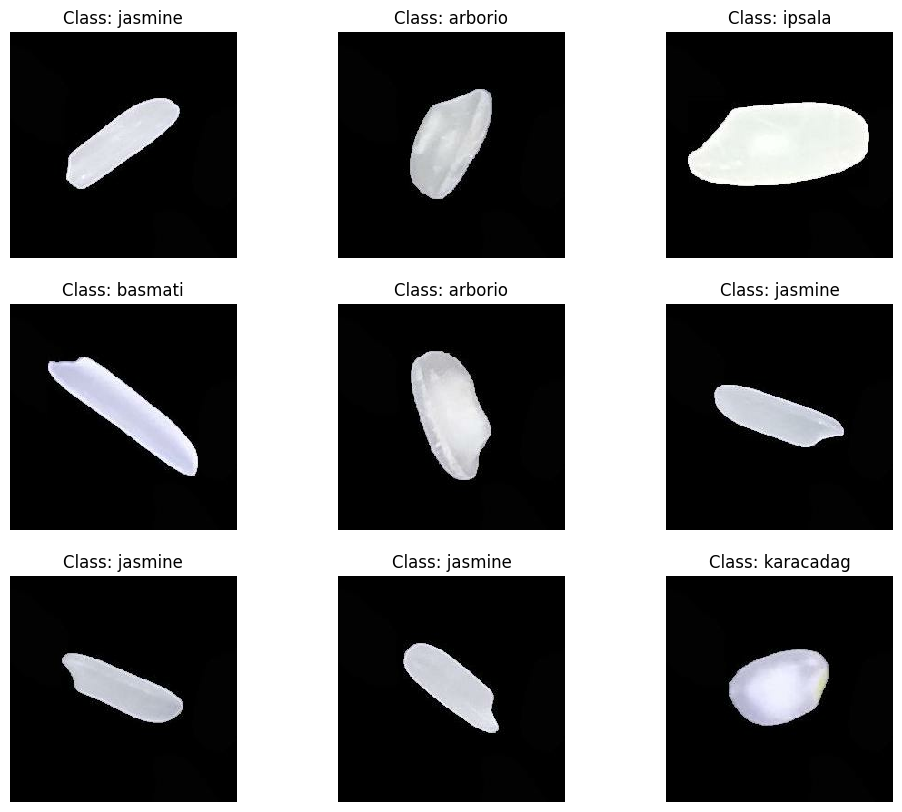

In [4]:
class_names = ['arborio', 'basmati', 'ipsala', 'jasmine', 'karacadag']

plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

## Primera Implementación (_modelo_arroz_inicial.keras_)

### Definición de la arquitectura del modelo y capas iniciales

Aquí se inicializa un modelo secuencial, para empezar a construir nuestra red neuronal capa por capa en un stack lineal. Este tipo de modelo ayuda a dividir la tarea de diseño en subtareas que se ejecutan una tras otra.

En la capa de entrada, especificamos el tamaño de cada imagen y que se usarán 3 canales de colores, como mencionado anteriormente debido al sombreado o variaciones en los tonos que se pueden observar.

In [5]:
modelo1 = Sequential()
modelo1.add(keras.layers.Input(shape=(250, 250, 3)))    # RGB

Posteriormente se agregan 3 capas de modificaciones randomizadas, con la finalidad de introducir data augmentation, ayudando a aumentar los datos al incluir información no contenida en el dataset original pero que puede ayudar durante el entrenamiento, añadiendo variaciones, reduciendo overfitting y mejorando la posible generalización que puede llegar a presentar.

Cada una de estas capas aplica de forma aleatoria una transformación distinta, para aportar una mayor gama de variación. En la primera de estas capas, se voltean aleatoriamente ciertas imágenes de manera horizontal durante el entrenamiento. En la segunda, se rotan aleatoriamente en un 10% para que aprenda independientemente a variaciones en orientaciones. La siguiente capa aplica aleatoriamente un aumento de imagen del 20%, enseñando independencia ante escalas y variabilidad, ya que el dataset original contiene imágenes muy similares en cuanto al tamaño de cada arroz.

Finalmente, una vez que se ha aplicado cierta Data Augmentation, se normaliza la información con Rescaling, escalando los pixeles de [0, 255] a [0, 1], para estabilizar y agilizar el entrenamiento.

In [6]:
# Data Augmentation
modelo1.add(keras.layers.RandomFlip("horizontal"))
modelo1.add(keras.layers.RandomRotation(0.1))
modelo1.add(keras.layers.RandomZoom(0.2))
# Normalización con Rescaling
modelo1.add(keras.layers.Rescaling(1.0 / 255))

Una vez habiendo aumentado, variado y normalizado la información, se agregan capas de convolución y pooling.

Iniciamos con una capa de convolución de 32 filtros de 3x3, de modo que se extraigan diversos features de estas imágenes relativamente simples de arroz, y con una función de activación ReLU, que se encarga de mantener valores positivos y eliminar linearidad para aprender patrones complejos que se puedan encontrar.

Despúes se utiliza una capa de Max Pooling con un pool de 2x2, reduciendo el tamaño de los feature maps para prevenir un overfit con información que no nos importa y agilizar la computación, refinando la imagen manteniendo los valores importantes extraidos.

Finalmente, se añaden 2 capas más. En la primera de estas capas, se aplica una convolución de nuevo, pero esta vez de 64 filtros, volviendo más exhaustivo el aprendizaje de features y patrones más abstractos y complejos, aumentando la profundidad. Y después de esta capa, se aplica una vez más un Max Pooling de 2x2, reduciendo una vez más el tamaño de los nuevos feature maps y refinando la información y aprendiendo features de más alto nivel, agilizando y mejorando el entrenamiento.

In [7]:
modelo1.add(keras.layers.Conv2D(32, 3, activation='relu'))  # Capa 1 de Convolución de 3x3
modelo1.add(keras.layers.MaxPool2D(pool_size=2))            # Capa 1 de Max Pooling de 2x2
modelo1.add(keras.layers.Conv2D(64, 3, activation='relu'))  # Capa 2 de Convolución de 3x3
modelo1.add(keras.layers.MaxPool2D(pool_size=2))            # Capa 2 de Max Pooling de 2x2

Este diseño y capas agregadas a nuestra red neuronal dan gran robustez y calidad a la red creada y mejoran en gran medida el output, ya que, al ser un dataset de imágenes que están dentro de un control y un estándar de fotografiado, agiliza y facilita el entrenamiento del modelo, y aunado con estas capas que agregan variabilidad, reducen overfit, e identifican features complejos y abstractos, se puede esperar una precisión muy alta y una pérdida baja.

### Agregar capas fully connected y la capa de output

Ahora, para las capas finales, se utilizan capas densas para compilar lo aprendido en la convolución y dar una respuesta informada como output sobre a qué clase es que pueden pertenecer cada cada imagen, con probabilidades de cada clase.

Previo a utilizar las capas densas, se utiliza una capa de aplanado, para convertir los feature maps obtenidos de las convoluciones en vectores unidimensionales, con la finalidad de convertir información espacial en un formato de una sola dimensión que a las capas densas puedan recibir.

La siguiente y penúltima capa es densa, conformada por 64 unidades y una acivación ReLU; esta capa, al ser densa, combina los features aprendidos de las convoluciones previas, permitiendo un aprendizaje de patrones complejos y relaciones que puede haber entre estos.

Finalmente, se agrega la capa de salida. Esta capa, también densa, tiene una activación softmax, ideal para clasificación multi clases, como esta de arroces, al dar como resultado un vector con una distribución de probabilidades, y esta, al tener 5 unidades, presenta las probabilidades de que la imagen recibida corresponda a alguna de las 5 clases de arroz, funcionando como capa de output final y de la predicción dada por el modelo.

In [8]:
modelo1.add(keras.layers.Flatten())                     # Se aplanan
modelo1.add(keras.layers.Dense(64, activation='relu'))  # Capa densa que recibe el vector de 1D
modelo1.add(keras.layers.Dense(5, activation='softmax'))# Capa de salida con softmax

### Compilación del modelo

Ahora se hace la compilación del modelo. En esta, se utiliza la función de pérdida de Sparse Categorical Crossentropy, ya que, al ser un problema categórico de varias clases resulta útil, además de que internamente, el modelo da como respuesta números enteros del 0 al 4, siendo más apropiada a que si estuvieran one-hot encodeados. Se optimiza con un gradient descent estocástico, ajustando los pesos con base en el error acumulado, siendo capaz de encontrar patrones durante el entrenamiento. Finalmente, especificamos que queremos tener presente el accuracy como métrica de evaluación del modelo, monitoreando qué tan bien se clasifican las imágenes.

In [9]:
modelo1.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

### Entrenamiento del modelo

Ahora se entrena el modelo. Durante el entrenamiento se incluye un único callback, de forma más específica un early stopping, de modo que al detectar que la variable seleccionada para monitorear, en este caso val_loss, no mejora tras 3 epocas, se termina el entrenamiento y se utilizan los mejores parámetros para los pesos.

Una vez definido este callback que se utilizará durante el entrenamiento, se inicia el entrenamiento del modelo, el cual durará 15 épocas o menos, según del callack de early stopping diseñado. El entrenamiento estará validado en el conjunto de datos de validación, previamente seleccionado. Gracias a la función fit, además de entrenar el modelo, será posible almacenar en una variable el historial de entrenamiento, con las métricas de entrenamiento y validación, para su posterior visualización.

In [10]:
callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

history1 = modelo1.fit(train_dataset, epochs=15, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.6155 - loss: 0.9230 - val_accuracy: 0.8513 - val_loss: 0.3200
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8405 - loss: 0.3997 - val_accuracy: 0.8980 - val_loss: 0.2386
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.8846 - loss: 0.3030 - val_accuracy: 0.9227 - val_loss: 0.2061
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9016 - loss: 0.2657 - val_accuracy: 0.9567 - val_loss: 0.1334
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 218s 995ms/step - accuracy: 0.9074 - loss: 0.2430 - val_accuracy: 0.9600 - val_loss: 0.1366
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 218s 993ms/step - accuracy: 0.9128 - loss: 0.2255 - val_accuracy: 0.9320 - val_loss: 0.1969
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 218s 994ms/step - accuracy: 0.9121 - loss: 0.2226 - val_accuracy: 0.9393 - val_loss: 0.1528


Se puede ver que el early stopping actuó como esperado, y tras ver que el cal_loss no vio mejoras tras 3 épocas, decidió detener el entrenamiento.

Ahora, una vez entrenado el modelo, lo guardamos como un archivo de keras, para su posible uso más adelante.

In [11]:
modelo1.save("modelo_arroz_inicial.keras")

### Visualización y evaluación del desempeño del modelo

Ahora, una vez que tenemos el modelo entrenado y listo para realizar predicciones, mostramos diferentes resultados gráficamente sobre el desempeño en entrenamiento y predicciones para clasificar imágenes con un conjunto de datos no visto durante el entrenamiento.

Primero se muestran las gráficas de pérdida y accuracy durante el entrenamiento, con el conjunto de entrenamiento comparado con el conjunto de validación, y observando el ajuste y próxima convergencia en ambos casos.

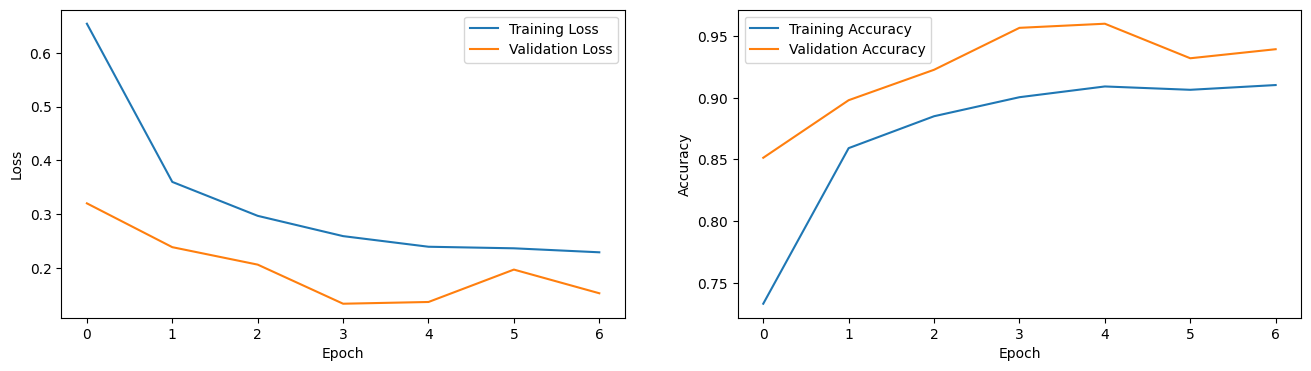

In [ ]:
# Graficación de los resultados del entrenamiento
plt.figure(figsize=(16, 4))

# Gráfica de pérdida
plt.subplot(121)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfica de accuracy
plt.subplot(122)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Ahora se muestra la evaluación de la pérdida y accuracy del modelo con el conjunto de datos de test:

In [ ]:
test_loss1, test_acc1 = modelo1.evaluate(test_dataset)
print(f"Pérdida: {test_loss1:.2f}")
print(f"Accuracy: {test_acc1:.3f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 279ms/step - accuracy: 0.9651 - loss: 0.1138
Pérdida: 0.13
Accuracy: 0.955


Por las gráficas mostradas, podemos observar claramente cómo es que ambas líneas tienden a converger, sin embargo, no convergen de forma satisfactoria durante el entrenamiento, aunque realmente los números del entrenamientos son muy altos, observando que el accuracy es alto al ver el eje de las y, terminando aproximadamente en un 90%. Además, una vez evaluado el modelo con el conjunto de test, podemos ver que efectivamente fue entrenado de una manera muy correcta, subiendo hasta un 95.5% de accuracy y una pérdida muy baja. Esto nos muestra que realmente el modelo no presentó un overfit significativo y la red fue diseñada de forma robusta.

Para evaluar de forma final el modelo, a continuación se presentan ciertas predicciones sobre una muestra del conjunto de pruebas, para comprobar la eficacia y confiabilidad del modelo.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


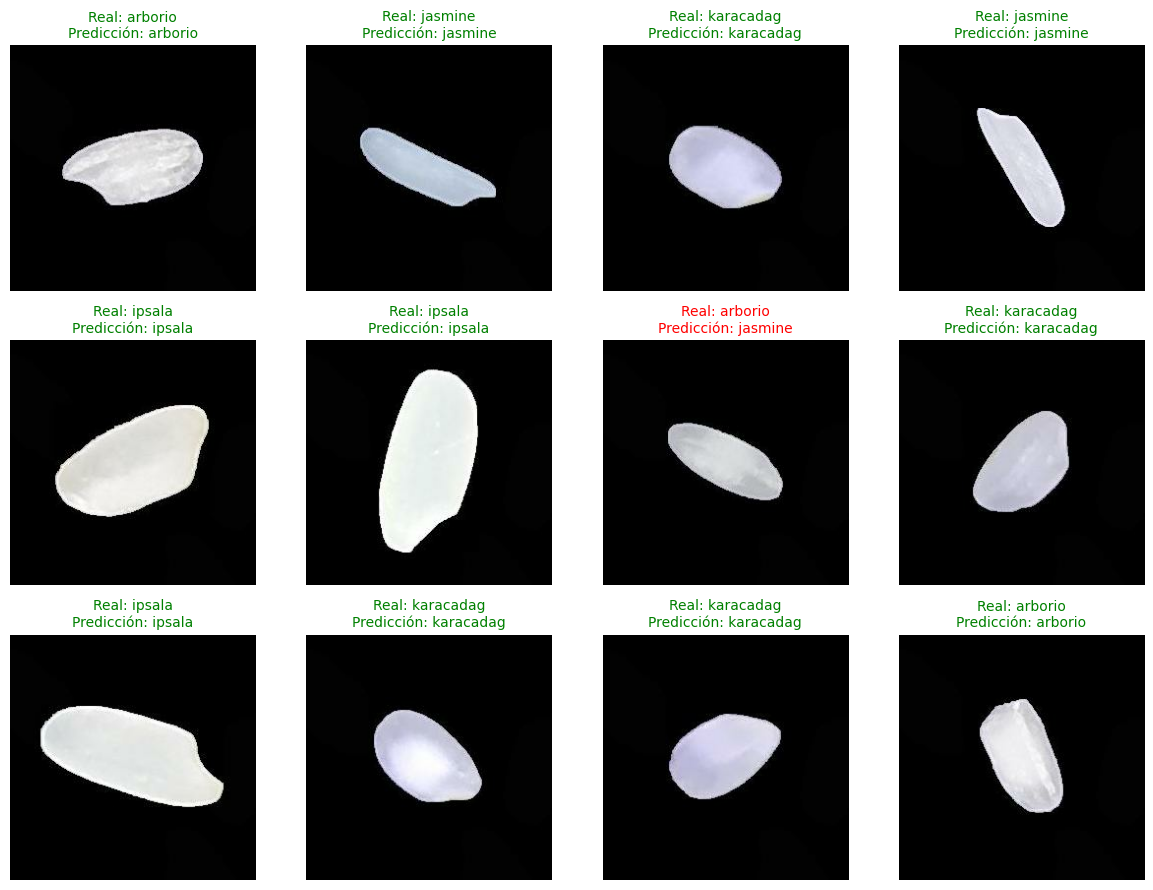

In [ ]:
# Predicciones con el conjunto de pruebas
test_images, test_labels = next(iter(test_dataset))     # Imágenes y sus clases de prueba 
predicciones1 = modelo1.predict(test_images)
predicted_labels = np.argmax(predicciones1, axis=1)     # Convertir las probabilidades que saca el modelo en los índices mencionados (0 a 4)

# Se grafican las imágenes, con su valor real y la predicción
plt.figure(figsize=(12, 9))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))

    # Se guardan los nombres de las clases predichas y de las reales
    real_label = class_names[test_labels[i].numpy()]
    pred_label = class_names[predicted_labels[i]]

    # Se muestran los resultados de forma comparativa, siendo rojos en caso de estar errónea la predicción y verdes en caso de ser correcta
    plt.title(f"Real: {real_label}\nPredicción: {pred_label}", fontsize=10, color=("green" if real_label == pred_label else "red"))
    plt.axis("off")

plt.tight_layout()
plt.show()

### Conclusión del primer modelo

Esta estructura combina data augmentation, la extracción de features mediante convolución y la clasificación mediante capas densas. Cada parte del diseño ayuda a que el modelo se generalice bien en imágenes de arroz no vistas, clasificándolas con precisión en las cinco clases especificadas, como se puede observar en las predicciones previas, de la muestra de 12 imágenes, se predijeron correctamente 11. Esto habla bien del modelo entrenado y de que el preprocesamiento de las imágenes fue adecuado en este caso, sin embargo, es posible mejorarlo, ya que como se acaba de ver, con un diseño e implementación muy básicos de una red neuronal fue posible tener un accuracy muy elevado, es posible ver una mejora notable en caso de agregar cierta complejidad al diseño de la red, mejorando esta incluso más y dando un accuracy impresionante.

In [44]:
class ResidualUnit1(keras.layers.Layer):
    def __init__(self, filters, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False)
        self.bn1 = keras.layers.BatchNormalization()
        self.activation = keras.layers.Activation("relu")
        self.conv2 = keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False)
        self.bn2 = keras.layers.BatchNormalization()
        
        if strides > 1:
            self.skip_conv = keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False)
        else:
            self.skip_conv = None

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        skip = self.skip_conv(inputs) if self.skip_conv is not None else inputs
        return keras.layers.add([x, skip])

In [ ]:
# Define model architecture with custom residual units and adjusted input shape
modelo2 = Sequential()
modelo2.add(keras.layers.Input(shape=(250, 250, 3)))

# Data Augmentation and Preprocessing
modelo2.add(keras.layers.RandomFlip("horizontal"))
modelo2.add(keras.layers.RandomRotation(0.1))
modelo2.add(keras.layers.RandomZoom(0.2))
modelo2.add(keras.layers.Rescaling(1./255))

modelo2.add(keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False))
modelo2.add(keras.layers.BatchNormalization())
modelo2.add(keras.layers.Activation("relu"))

# Initial Conv Block
modelo2.add(ResidualUnit1(64))
modelo2.add(keras.layers.MaxPool2D())
modelo2.add(ResidualUnit1(128, strides=2))
modelo2.add(keras.layers.MaxPool2D())
modelo2.add(ResidualUnit1(256, strides=2))

In [ ]:
modelo2.add(keras.layers.GlobalAvgPool2D())
modelo2.add(keras.layers.Dense(5, activation="softmax"))

In [ ]:
# Compile the model
modelo2.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
callbacks2 = [ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-5)]

# Train the model
history2 = modelo2.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=callbacks2)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 878s 4s/step - accuracy: 0.7526 - loss: 0.7171 - val_accuracy: 0.2007 - val_loss: 4.5991 - learning_rate: 0.0100
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 780s 4s/step - accuracy: 0.9293 - loss: 0.2342 - val_accuracy: 0.5493 - val_loss: 2.0000 - learning_rate: 0.0100
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 863s 4s/step - accuracy: 0.9464 - loss: 0.1816 - val_accuracy: 0.9780 - val_loss: 0.1283 - learning_rate: 0.0100
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 861s 4s/step - accuracy: 0.9610 - loss: 0.1297 - val_accuracy: 0.9880 - val_loss: 0.0581 - learning_rate: 0.0100
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 779s 4s/step - accuracy: 0.9706 - loss: 0.1073 - val_accuracy: 0.9440 - val_loss: 0.1693 - learning_rate: 0.0100
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 773s 4s/step - accuracy: 0.9676 - loss: 0.1055 - val_accuracy: 0.3933 - val_loss: 5.1342 - learning_rate: 0.0100
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 769s 4s/step - accuracy: 0.9613 - loss: 0.

In [ ]:
modelo2.save("modelo_arroz_mejorado.keras")

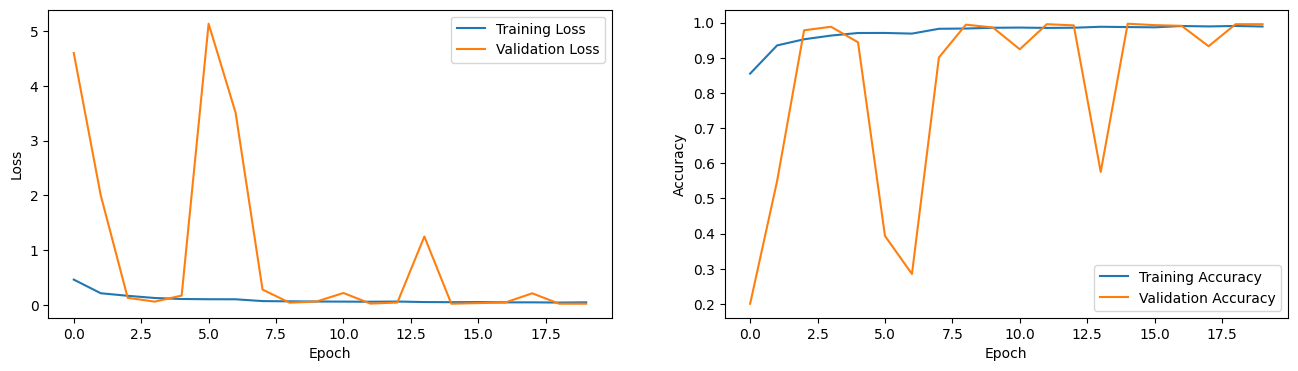

In [ ]:
# Plot training results
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate on validation set as test
test_loss2, test_acc2 = modelo2.evaluate(test_dataset)
print(f"Pérdida: {test_loss2:.2f}")
print(f"Accuracy: {test_acc2:.3f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 676ms/step - accuracy: 0.9963 - loss: 0.0325
Pérdida: 0.03
Accuracy: 0.996


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


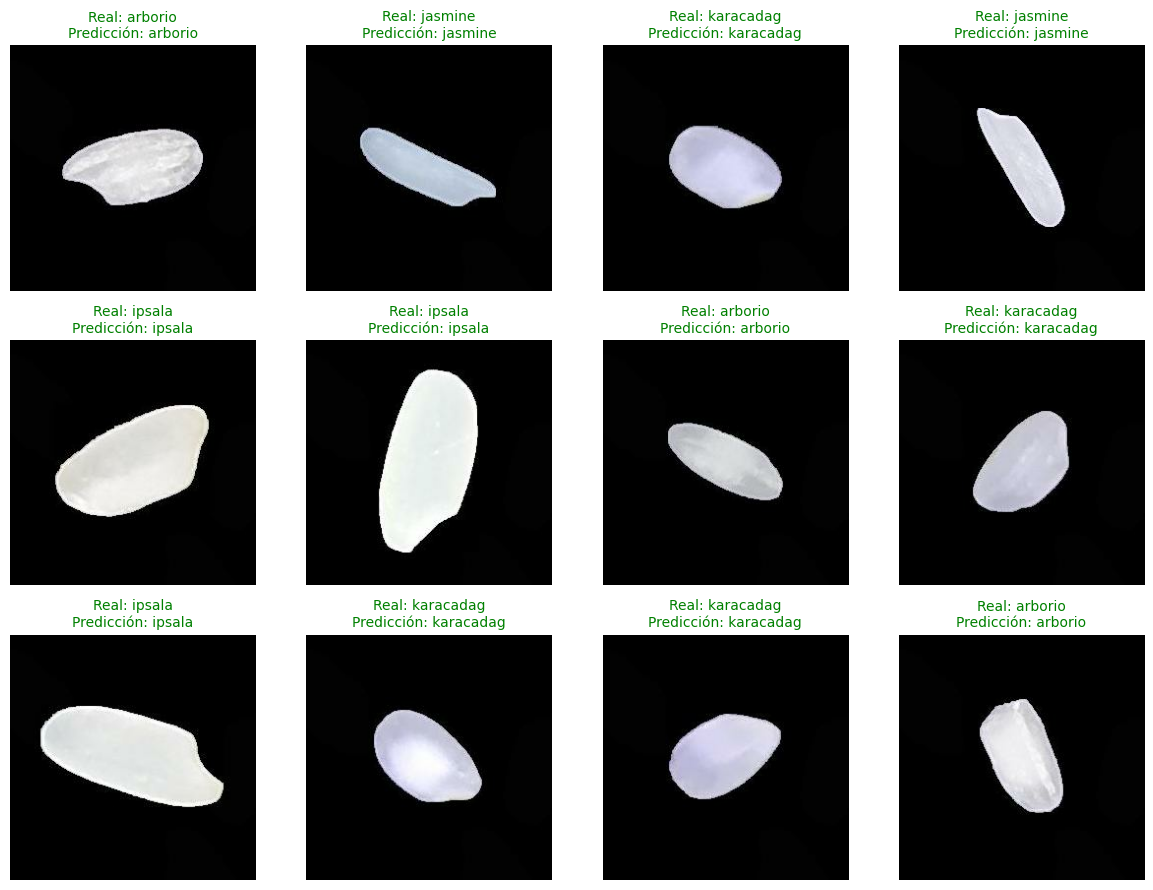

In [ ]:
# Generate predictions on the test dataset
test_images, test_labels = next(iter(test_dataset))  # Get a batch of test images and labels
predictions = modelo2.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to label indices

# Plotting the 3x4 grid of images
plt.figure(figsize=(12, 9))  # Adjust size as needed
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))  # Convert tensor to uint8 format

    # Get true and predicted label names
    real_label = class_names[test_labels[i].numpy()]
    pred_label = class_names[predicted_labels[i]]

    # Display names with color coding for correct or incorrect predictions
    plt.title(f"Real: {real_label}\nPredicción: {pred_label}", fontsize=10, color=("green" if real_label == pred_label else "red"))
    plt.axis("off")  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()

In [24]:
class SEBlock(layers.Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        super().__init__(**kwargs)
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(filters // reduction, activation="relu")
        self.dense2 = layers.Dense(filters, activation="sigmoid")

    def call(self, inputs):
        se = self.global_avg_pool(inputs)
        se = self.dense1(se)
        se = self.dense2(se)
        se = layers.Reshape((1, 1, -1))(se)
        return layers.multiply([inputs, se])

In [ ]:
class ResidualUnitFinal(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.SeparableConv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.SeparableConv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.SeparableConv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]
        
        self.se_block = SEBlock(filters)

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
# Define model architecture with custom residual units and adjusted input shape
model = Sequential()
model.add(keras.layers.Input(shape=(250, 250, 3)))  # Adjust to (600, 600, 3)

# Data Augmentation and Preprocessing
model.add(keras.layers.RandomFlip("horizontal"))
model.add(keras.layers.RandomRotation(0.1))
model.add(keras.layers.RandomZoom(0.2))
model.add(keras.layers.Rescaling(1./255))

# Initial Conv Block
model.add(keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

In [ ]:
# Add Residual Blocks
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnitFinal(filters, strides=strides))
    prev_filters = filters

c:\Users\saaso\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'residual_unit_32', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\saaso\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'residual_unit_33', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\saaso\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\s

In [28]:
# Global Average Pooling and Output Layer
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(5, activation="softmax"))

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=AdamW(learning_rate=1e-3), metrics=["accuracy"])

In [ ]:
# Train the model
callbacks = [ModelCheckpoint("resnet_arroz.keras", save_best_only=True, monitor="val_loss"),
             ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-5)]

history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1324s 6s/step - accuracy: 0.7450 - loss: 0.6808 - val_accuracy: 0.2000 - val_loss: 2.8504 - learning_rate: 0.0010
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1273s 6s/step - accuracy: 0.9471 - loss: 0.1598 - val_accuracy: 0.2000 - val_loss: 9.2824 - learning_rate: 0.0010
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1279s 6s/step - accuracy: 0.9583 - loss: 0.1097 - val_accuracy: 0.6567 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1433s 7s/step - accuracy: 0.9678 - loss: 0.0910 - val_accuracy: 0.4533 - val_loss: 3.6355 - learning_rate: 0.0010
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1483s 7s/step - accuracy: 0.9727 - loss: 0.0735 - val_accuracy: 0.3967 - val_loss: 24.6031 - learning_rate: 0.0010
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1507s 7s/step - accuracy: 0.9734 - loss: 0.0823 - val_accuracy: 0.8167 - val_loss: 1.0619 - learning_rate: 0.0010
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1308s 6s/step - accuracy: 0.9658 - 

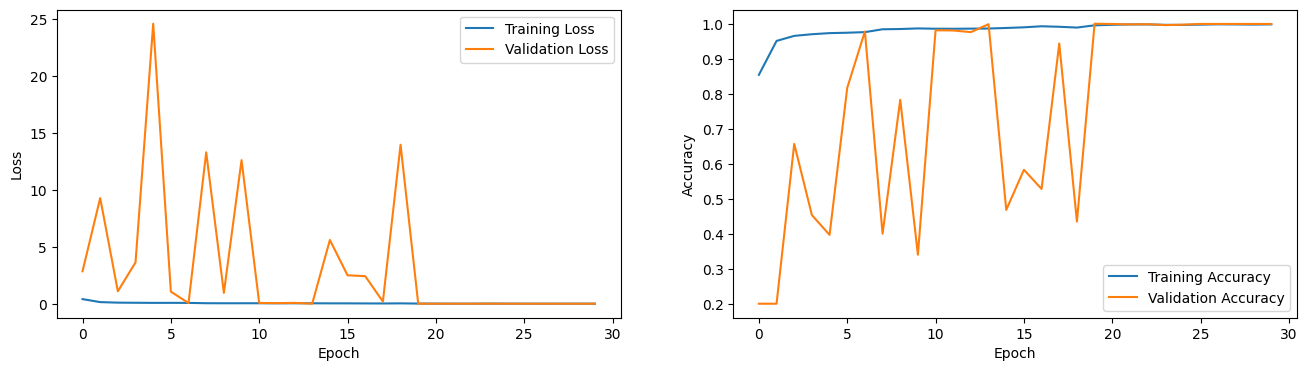

In [34]:
# Plot training results
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
# Evaluate on validation set as test
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Pérdida: {test_loss:.2f}")
print(f"Accuracy: {test_acc:.3f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9966 - loss: 0.0094
Pérdida: 0.01
Accuracy: 0.997


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


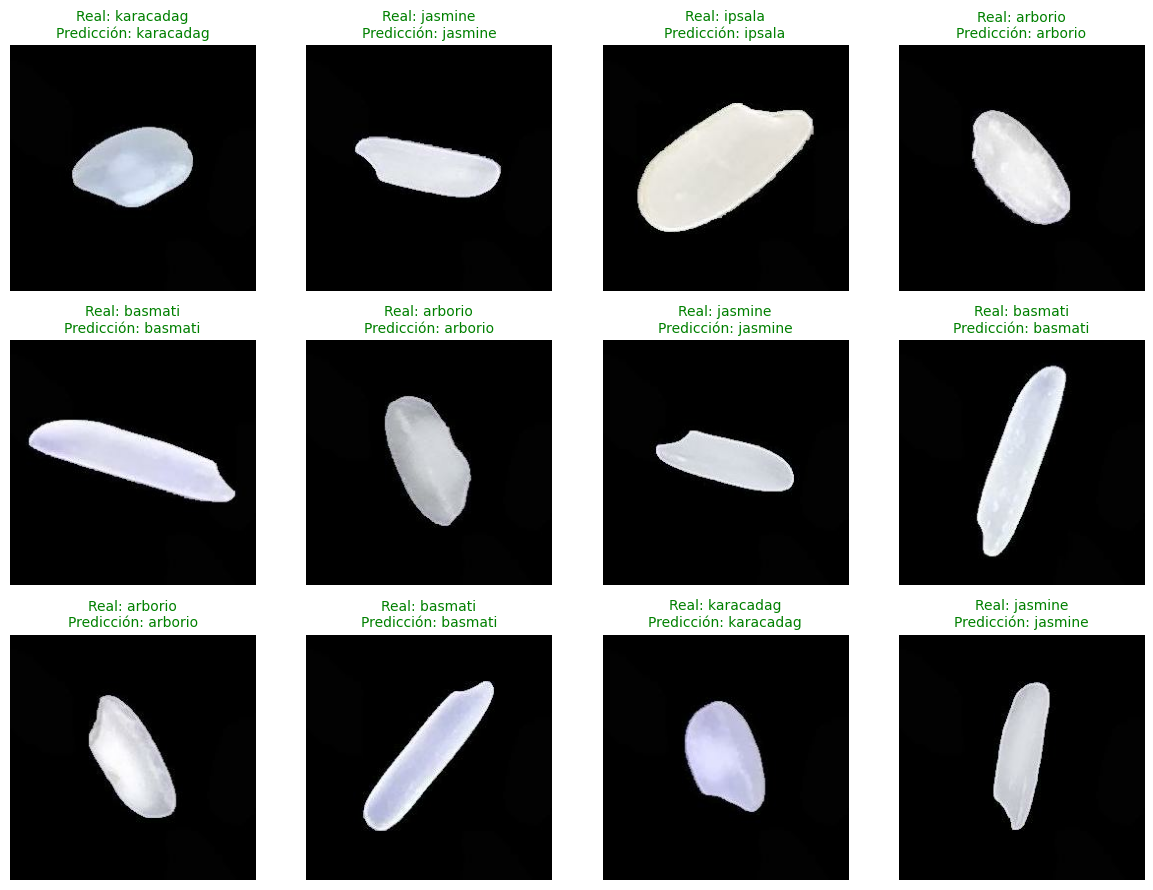

In [39]:
# Generate predictions on the test dataset
test_images, test_labels = next(iter(test_dataset))  # Get a batch of test images and labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to label indices

# Plotting the 3x4 grid of images
plt.figure(figsize=(12, 9))  # Adjust size as needed
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))  # Convert tensor to uint8 format

    # Get true and predicted label names
    real_label = class_names[test_labels[i].numpy()]
    pred_label = class_names[predicted_labels[i]]

    # Display names with color coding for correct or incorrect predictions
    plt.title(f"Real: {real_label}\nPredicción: {pred_label}", fontsize=10, color=("green" if real_label == pred_label else "red"))
    plt.axis("off")  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()